# eICU Collaborative Research Database

Before starting this workshop, you will need to copy the eicu demo database file ('eicu_demo.sqlite3') to the `data` directory.

Documentation on the eICU Collaborative Research Database can be found at: http://eicu-crd.mit.edu/.



## Example project

This notebook overviews an example project which uses the eICU Collaborative Research Database. The project focuses on acute kidney injury, and quantifying the difference between patients who have the condition versus those who do not.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import os

In [2]:
# Plot settings
%matplotlib inline
plt.style.use('ggplot')
fontsize = 20 # size for x and y ticks
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams.update({'font.size': fontsize})

In [3]:
# Connect to the database
fn = os.path.join('data','eicu_demo.sqlite3')
con = sqlite3.connect(fn)
cur = con.cursor()

## 1. Define the cohort

Our first step is to define the patient population we are interested in. For this project, we'd like to identify those patients with any past history of renal failure and compare them with the remaining patients.

First, we extract all patient unit stays from the patient table.

In [4]:
query = \
"""
SELECT patientunitstayid
FROM patient
"""

df = pd.read_sql_query(query,con)

Now we investigate the pasthistory table, and look at all the mentions of past history which contain the phrase `'Renal  (R)'` - note we use `%` as they are wildcard characters for SQL.

In [5]:
query = \
"""
SELECT pasthistorypath, count(*) as n
FROM pasthistory
WHERE pasthistorypath LIKE '%Renal  (R)%'
GROUP BY pasthistorypath
ORDER BY n DESC;
"""

ph = pd.read_sql_query(query,con)

for row in ph.iterrows():
    r = row[1]
    print('{:3g} - {:20s}'.format(r['n'],r['pasthistorypath'][48:]))

182 - Renal  (R)/Renal Failure/renal failure - hemodialysis
124 - Renal  (R)/Renal Insufficiency/renal insufficiency - baseline creatinine unknown
109 - Renal  (R)/Renal Insufficiency/renal insufficiency - creatinine 1-2
105 - Renal  (R)/Renal Insufficiency/renal insufficiency - creatinine 2-3
 68 - Renal  (R)/Renal Failure/renal failure- not currently dialyzed
 33 - Renal  (R)/Chronic Stone Disease/chronic kidney stones
 15 - Renal  (R)/s/p Renal Transplant/s/p renal transplant
  7 - Renal  (R)/Renal Failure/renal failure - peritoneal dialysis
  4 - Renal  (R)/Renal Insufficiency/renal insufficiency - creatinine 3-4
  3 - Renal  (R)/Neurogenic Bladder/neurogenic bladder
  2 - Renal  (R)/Renal Insufficiency/renal insufficiency - creatinine > 5


These all seem like reasonable surrogates for renal insufficiency (note: for a real clinical study, you'd want to be a lot more thorough!).

In [6]:
# identify patients with insufficiency

query = \
"""
SELECT DISTINCT patientunitstayid
FROM pasthistory
WHERE pasthistorypath LIKE '%Renal  (R)%'
"""

df_have_crf = pd.read_sql_query(query,con)
df_have_crf['crf'] = 1

In [7]:
# merge the above data into our original dataframe

df = df.merge(df_have_crf, how='left',
              left_on='patientunitstayid', right_on='patientunitstayid')
df.head()

,patientunitstayid,crf
0,165840,1.0
1,165841,NaN
2,193119,NaN
3,193120,NaN
4,147894,NaN


In [8]:
# impute 0s for the missing CRF values
df.fillna(value=0,inplace=True)
df.head()

,patientunitstayid,crf
0,165840,1.0
1,165841,0.0
2,193119,0.0
3,193120,0.0
4,147894,0.0


In [9]:
# set patientunitstayid as the index - convenient for indexing later
df.set_index('patientunitstayid',inplace=True)

## 2. Load creatinine from lab table

In [10]:
query = """
SELECT patientunitstayid, labresult
FROM lab
WHERE labname = 'creatinine'
"""

lab = pd.read_sql_query(query, con)

# set patientunitstayid as the index
lab.set_index('patientunitstayid',inplace=True)

In [11]:
# get first creatinine by grouping by the index (level=0)
cr_first = lab.groupby(level=0).first()

# similarly get maximum creatinine
cr_max = lab.groupby(level=0).max()

## 3. Plot distributions of creatinine in both groups

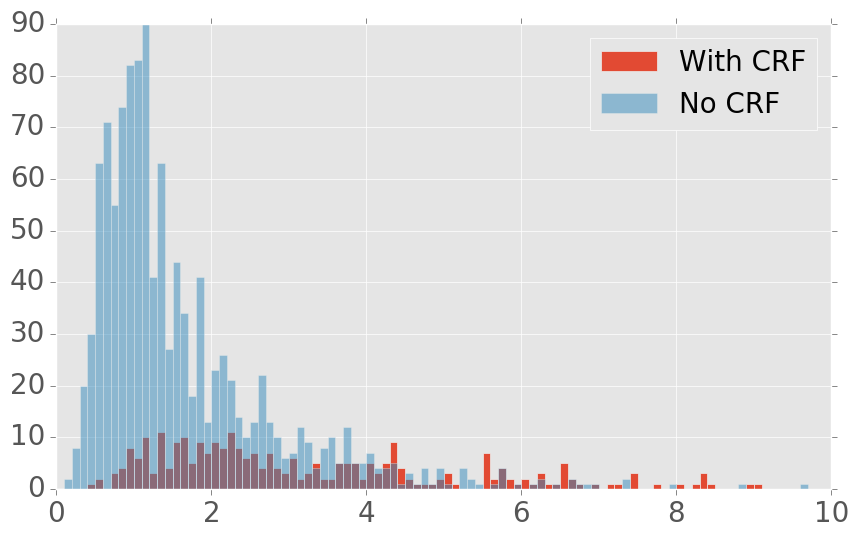

In [12]:
plt.figure(figsize=[10,6])

xi = np.arange(0,10,0.1)

# get patients who had CRF and plot a histogram
idx = df.loc[df['crf']==1,:].index
plt.hist( cr_first.loc[idx,'labresult'].dropna(), bins=xi, label='With CRF' )

# get patients who did not have CRF
idx = df.loc[df['crf']==0,:].index
plt.hist( cr_first.loc[idx,'labresult'].dropna(), alpha=0.5, bins=xi, label='No CRF' )

plt.legend()

plt.show()

While it appears that patients in the red group have higher creatinines, we have far more patients in the blue group (no CRF) than in the red group (have CRF). To alleviate this and allow a fairer comparison, we can normalize the histogram.

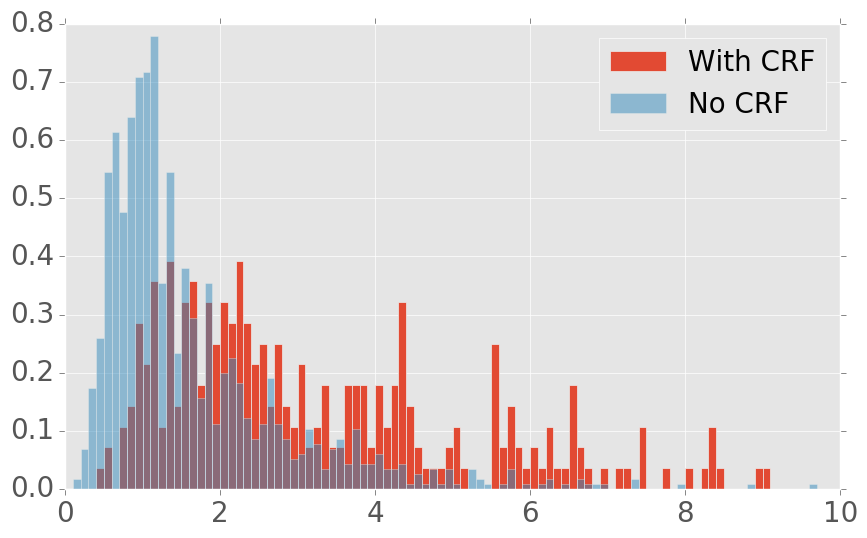

In [13]:
plt.figure(figsize=[10,6])

xi = np.arange(0,10,0.1)

# get patients who had CRF and plot a histogram
idx = df.loc[df['crf']==1,:].index
plt.hist( cr_first.loc[idx,'labresult'].dropna(), bins=xi, normed=True,
         label='With CRF' )

# get patients who did not have CRF
idx = df.loc[df['crf']==0,:].index
plt.hist( cr_first.loc[idx,'labresult'].dropna(), alpha=0.5, bins=xi, normed=True,
         label='No CRF' )

plt.legend()

plt.show()

Here we can very clearly see that the first creatinine measured is a lot higher for patients with some baseline kidney dysfunction when compared to those without. Let's try it with the highest value.

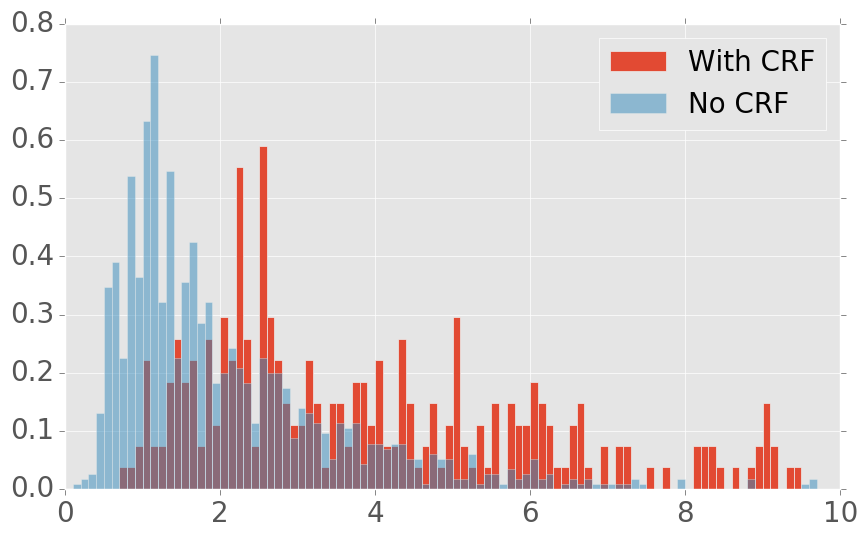

In [14]:
plt.figure(figsize=[10,6])

xi = np.arange(0,10,0.1)

# get patients who had CRF and plot a histogram
idx = df.loc[df['crf']==1,:].index
plt.hist( cr_max.loc[idx,'labresult'].dropna(), bins=xi, normed=True,
         label='With CRF' )

# get patients who did not have CRF
idx = df.loc[df['crf']==0,:].index
plt.hist( cr_max.loc[idx,'labresult'].dropna(), alpha=0.5, bins=xi, normed=True,
         label='No CRF' )

plt.legend()

plt.show()

Unsuprisingly, a very similar story!